<a href="https://colab.research.google.com/github/ruthagwall/AH2179_Project/blob/main/AH2179_TrafficFlow_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: prior to running the code, four datasets must be loaded. The training and evaluation datasets are provided via the course canvas page, and the weather data (temperature and precipitaiton) can be found in the GitHub repository.

#1. Data Preprocessing

##1.1 Load and Prepare the Data
In this section, the training dataset is loaded and studied. A few necessary variables are added to the dataset.

In [1]:
# load the data
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

df = pd.read_csv("training_dataset.csv",sep=";")

In [2]:
df.shape

(1921967, 11)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921967 entries, 0 to 1921966
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   DP_ID         int64  
 1   PORTAL        object 
 2   Date          int64  
 3   Time          object 
 4   Interval_1    int64  
 5   Interval_5    int64  
 6   Interval_15   int64  
 7   Interval_30   int64  
 8   Interval_60   int64  
 9   SPEED_MS_AVG  float64
 10  FLOW          float64
dtypes: float64(2), int64(7), object(2)
memory usage: 161.3+ MB


In [4]:
# check if date is in format yyyy-mm-dd
if not pd.api.types.is_datetime64_any_dtype(df['Date']):
    # convert date to correct format if needed
    df['Date'] = pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')

# create column for day of week, month, and hour
df['Day'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month_name()
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour

# create ID corresponding to day of week and month to be able to remove all string variables
day_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
df['Day_ID'] = df['Day'].map(day_mapping)

month_mapping = {'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
df['Month_ID'] = df['Month'].map(month_mapping)

df

,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Day,Month,Hour,Day_ID,Month_ID
0,543,"E4S 56,780",2021-06-01,04:00:00,240,48,16,8,4,19.34,10.0,Tuesday,June,4,2,6
1,539,"E4S 56,160",2021-06-01,04:00:00,240,48,16,8,4,19.64,9.0,Tuesday,June,4,2,6
2,534,"E4S 56,780",2021-06-01,04:00:00,240,48,16,8,4,23.36,5.0,Tuesday,June,4,2,6
3,351,"E4S 56,490",2021-06-01,04:00:00,240,48,16,8,4,20.14,7.0,Tuesday,June,4,2,6
4,353,"E4S 57,055",2021-06-01,04:00:00,240,48,16,8,4,17.70,7.0,Tuesday,June,4,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921962,353,"E4S 57,055",2021-12-31,10:00:00,600,120,40,20,10,17.45,11.0,Friday,December,10,5,12
1921963,543,"E4S 56,780",2021-12-31,10:00:00,600,120,40,20,10,18.09,11.0,Friday,December,10,5,12
1921964,153,"E4S 56,490",2021-12-31,10:00:00,600,120,40,20,10,23.53,7.0,Friday,December,10,5,12
1921965,351,"E4S 56,490",2021-12-31,10:00:00,600,120,40,20,10,18.49,9.0,Friday,December,10,5,12


##1.2 Add Weather Data
Data of air temperature and precipitation are added into the dataset to study their correlation to the flow and speed.

In [5]:
# Load in the weather datasets, convert their dates and remove data outside of our date interval.
temperature_df = pd.read_csv("temperature.csv",sep=";")
temperature_df.drop(columns=['Kvalitet'], inplace=True)

temperature_df['Datum'] = pd.to_datetime(temperature_df['Datum'])
temperature_df['Timme'] = pd.to_datetime(temperature_df['Tid (UTC)'], format='%H:%M:%S').dt.hour

start_date = '2021-06-01'
end_date = '2021-12-31'

temperature = temperature_df[(temperature_df['Datum'] >= start_date) & (temperature_df['Datum'] <= end_date)]
temperature.rename(columns={'Lufttemperatur': 'AirTemp'}, inplace=True)

rain_df = pd.read_csv("precipitation.csv", sep=";")

rain_df.drop(columns=['Kvalitet'], inplace=True)

rain_df['Datum'] = pd.to_datetime(rain_df['Datum'])
rain_df['Timme'] = pd.to_datetime(rain_df['Tid (UTC)'], format='%H:%M:%S').dt.hour

precipitation = rain_df[(rain_df['Datum'] >= start_date) & (rain_df['Datum'] <= end_date)]
precipitation.rename(columns={'Nederbördsmängd': 'Rain'}, inplace=True)


<ipython-input-5-3d863ecec4a5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature.rename(columns={'Lufttemperatur': 'AirTemp'}, inplace=True)
<ipython-input-5-3d863ecec4a5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precipitation.rename(columns={'Nederbördsmängd': 'Rain'}, inplace=True)


In [6]:
# Add the weather data into the dataframe by matching date and time.
df['Date'] = pd.to_datetime(df['Date'])

temp_df = pd.merge(df, temperature, left_on=['Date', 'Hour'], right_on=['Datum', 'Timme'], how='left')

temp_df.drop(columns=['Datum', 'Tid (UTC)', 'Timme'], inplace=True)

dataframe = pd.merge(temp_df, precipitation, left_on=['Date', 'Hour'], right_on=['Datum', 'Timme'], how='left')

dataframe.drop(columns=['Datum', 'Tid (UTC)', 'Timme'], inplace=True)

dataframe

,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Day,Month,Hour,Day_ID,Month_ID,AirTemp,Rain
0,543,"E4S 56,780",2021-06-01,04:00:00,240,48,16,8,4,19.34,10.0,Tuesday,June,4,2,6,9.4,0.0
1,539,"E4S 56,160",2021-06-01,04:00:00,240,48,16,8,4,19.64,9.0,Tuesday,June,4,2,6,9.4,0.0
2,534,"E4S 56,780",2021-06-01,04:00:00,240,48,16,8,4,23.36,5.0,Tuesday,June,4,2,6,9.4,0.0
3,351,"E4S 56,490",2021-06-01,04:00:00,240,48,16,8,4,20.14,7.0,Tuesday,June,4,2,6,9.4,0.0
4,353,"E4S 57,055",2021-06-01,04:00:00,240,48,16,8,4,17.70,7.0,Tuesday,June,4,2,6,9.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921962,353,"E4S 57,055",2021-12-31,10:00:00,600,120,40,20,10,17.45,11.0,Friday,December,10,5,12,4.6,0.0
1921963,543,"E4S 56,780",2021-12-31,10:00:00,600,120,40,20,10,18.09,11.0,Friday,December,10,5,12,4.6,0.0
1921964,153,"E4S 56,490",2021-12-31,10:00:00,600,120,40,20,10,23.53,7.0,Friday,December,10,5,12,4.6,0.0
1921965,351,"E4S 56,490",2021-12-31,10:00:00,600,120,40,20,10,18.49,9.0,Friday,December,10,5,12,4.6,0.0


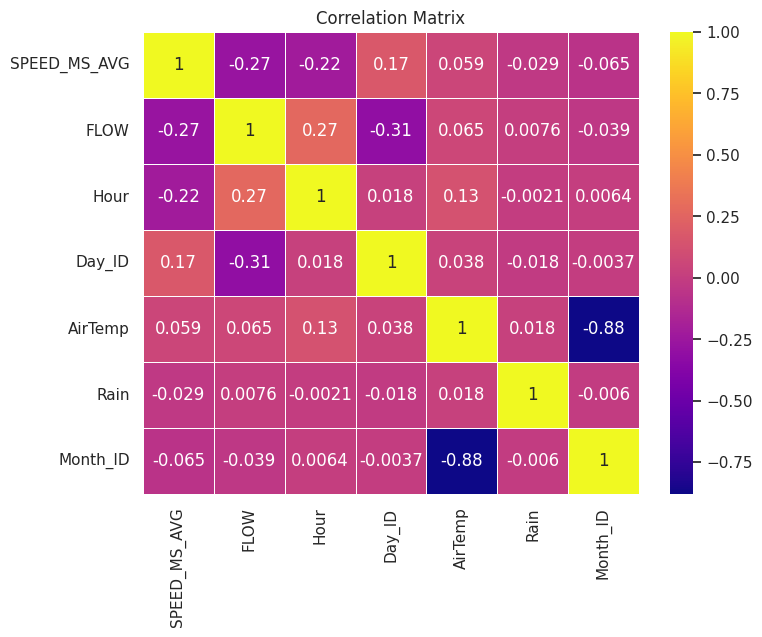

In [7]:
# Calculate the correlation matrix

corr_matrix = dataframe[['SPEED_MS_AVG', 'FLOW', 'Hour', 'Day_ID', 'AirTemp', 'Rain', 'Month_ID']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='plasma', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#2. Descriptive Analysis
Different statistics are computed to analyse the data.

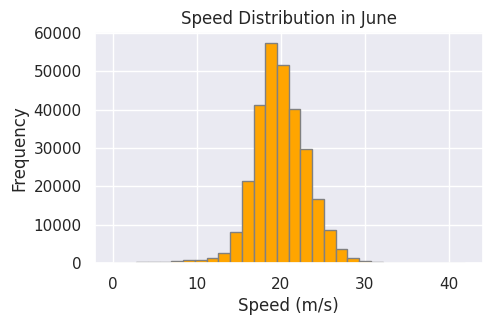

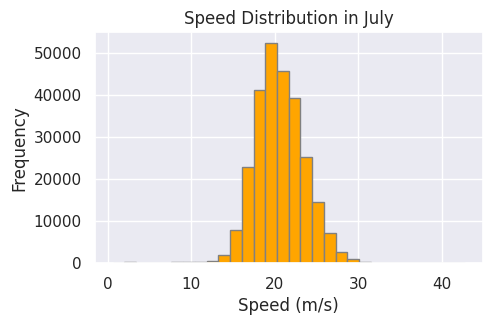

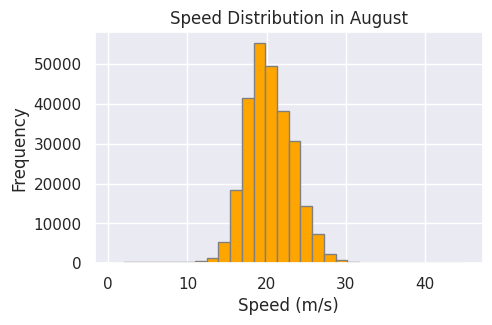

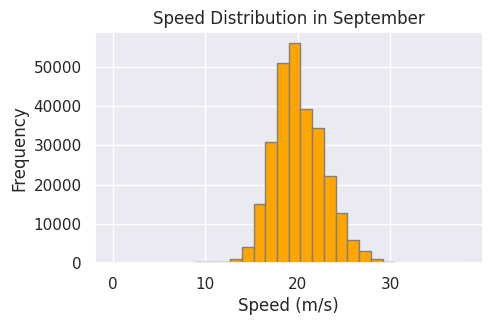

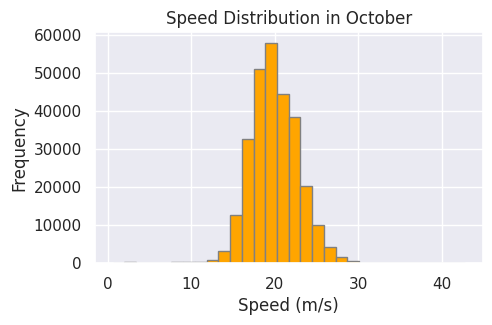

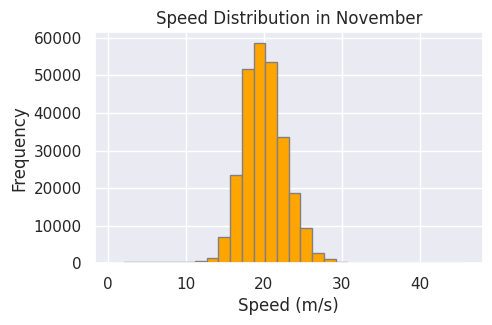

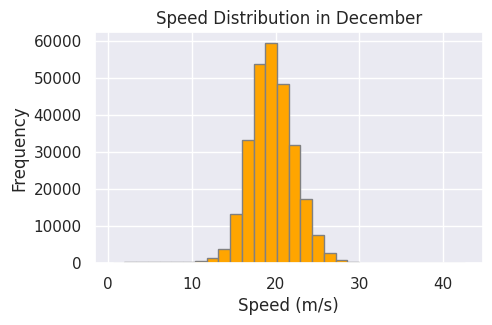

In [8]:
# Get the unique months in the dataset
unique_months = dataframe['Month'].unique()

# Loop through each unique month and create a histogram for each
for month in unique_months:
    # Filter data for the current month
    monthly_data = dataframe[dataframe['Month'] == month]

    # Plot histogram for the current month
    plt.figure(figsize=(5, 3))
    plt.grid(True)
    plt.hist(monthly_data['SPEED_MS_AVG'], bins=30, color='orange', edgecolor='gray')
    plt.title(f'Speed Distribution in {month}')
    plt.xlabel('Speed (m/s)')
    plt.ylabel('Frequency')
    plt.show()

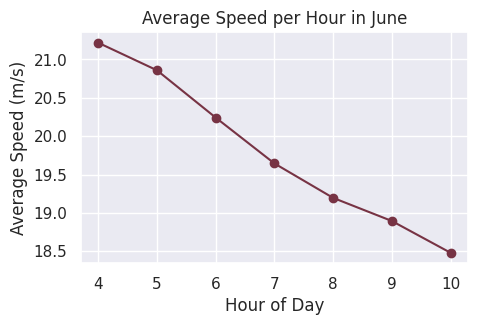

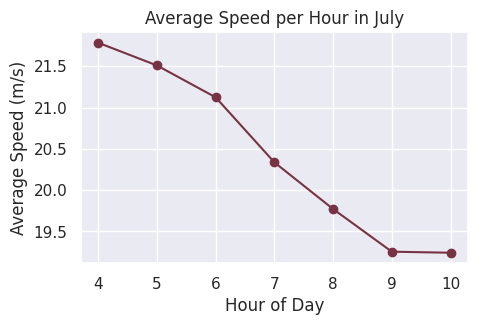

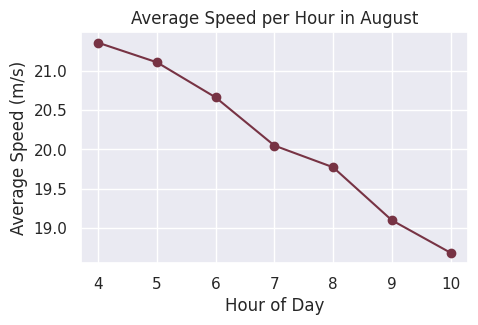

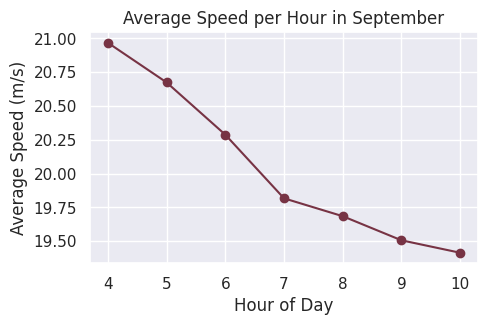

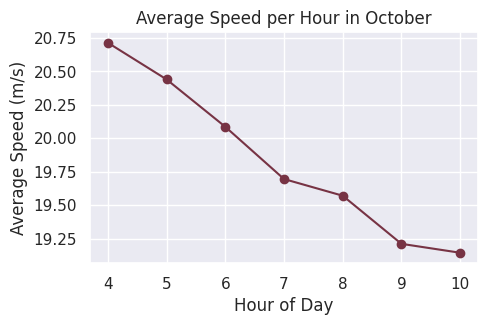

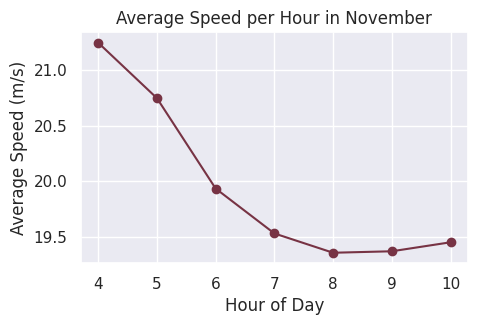

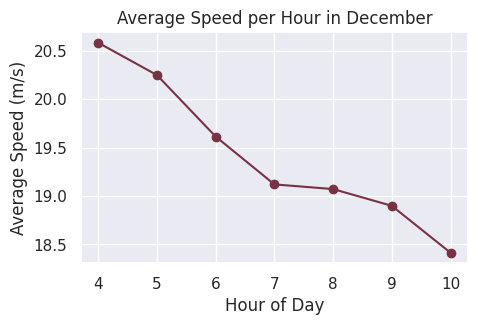

In [9]:
# calculate the average speed per hour for each month
for month in unique_months:

  hourly_avg_speed = dataframe[dataframe['Month'] == month].groupby('Hour')['SPEED_MS_AVG'].mean()

  plt.figure(figsize=(5, 3))
  plt.plot(hourly_avg_speed.index, hourly_avg_speed.values, marker='o', color='#773344')
  plt.title(f'Average Speed per Hour in {month}')
  plt.xlabel('Hour of Day')
  plt.ylabel('Average Speed (m/s)')
  plt.grid(True)
  plt.show()


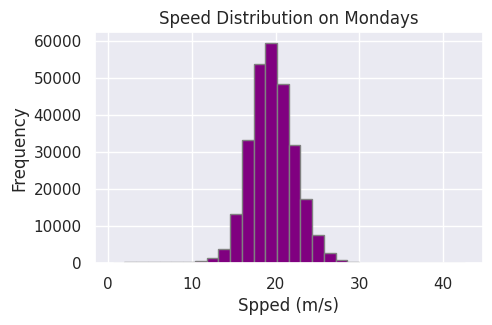

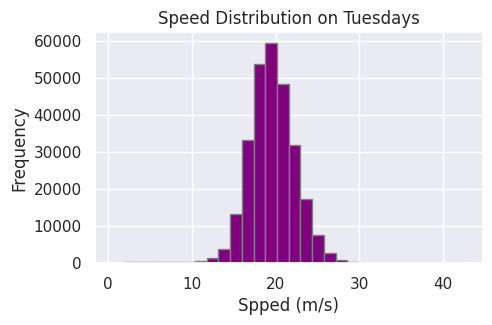

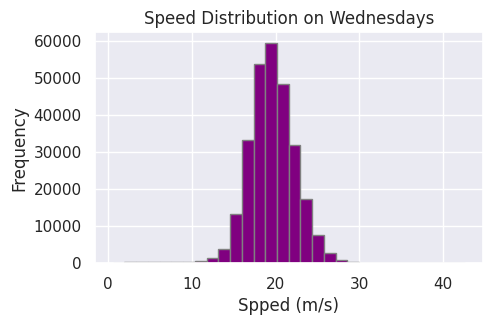

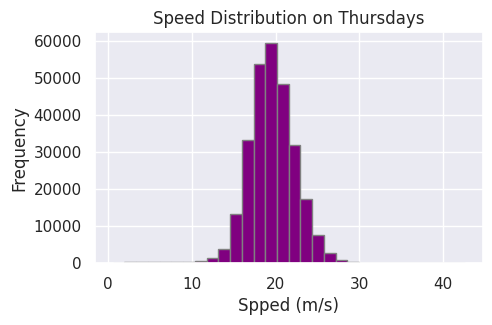

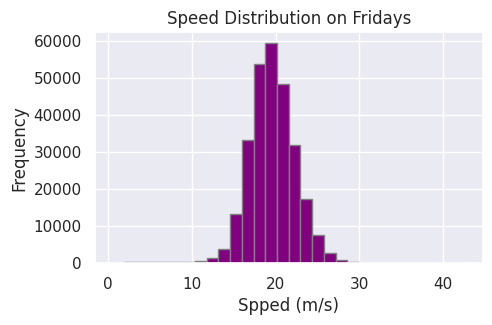

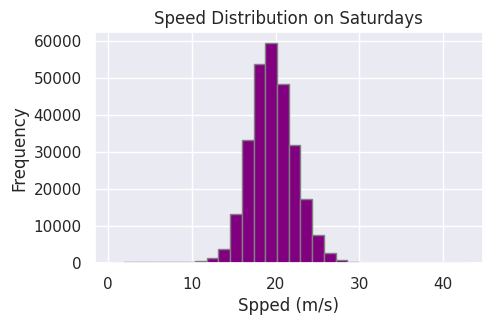

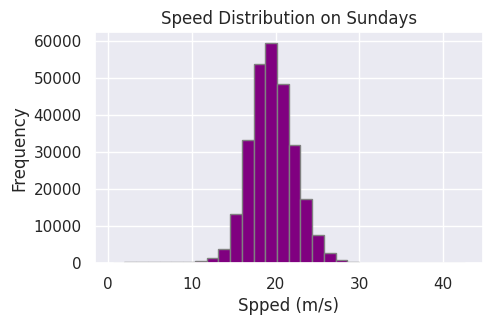

In [10]:
# Loop through each unique month and create a histogram for each
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for day in ordered_days:
    # Filter data for the current month
    daily_data = dataframe[dataframe['Day'] == day]

    # Plot histogram for the current month
    plt.figure(figsize=(5, 3))
    plt.hist(monthly_data['SPEED_MS_AVG'], bins=30, color='purple', edgecolor='gray')
    plt.title(f'Speed Distribution on {day}s')
    plt.xlabel('Spped (m/s)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

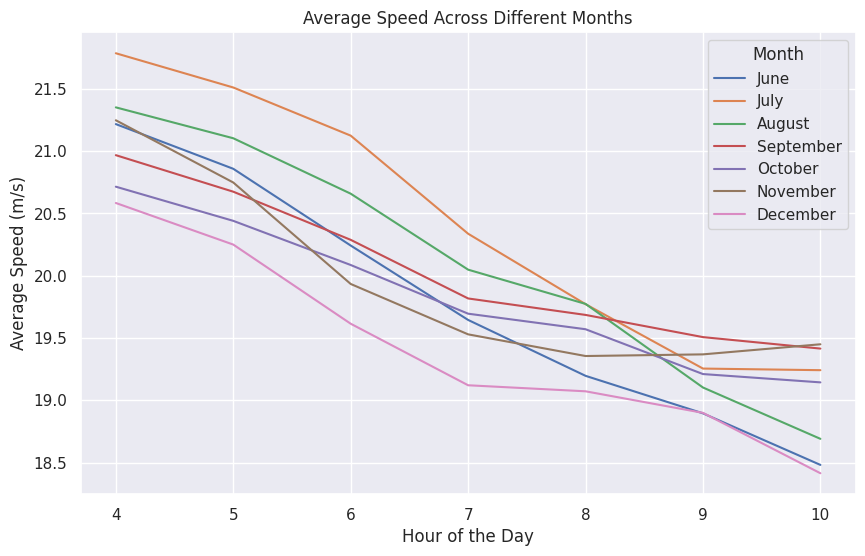

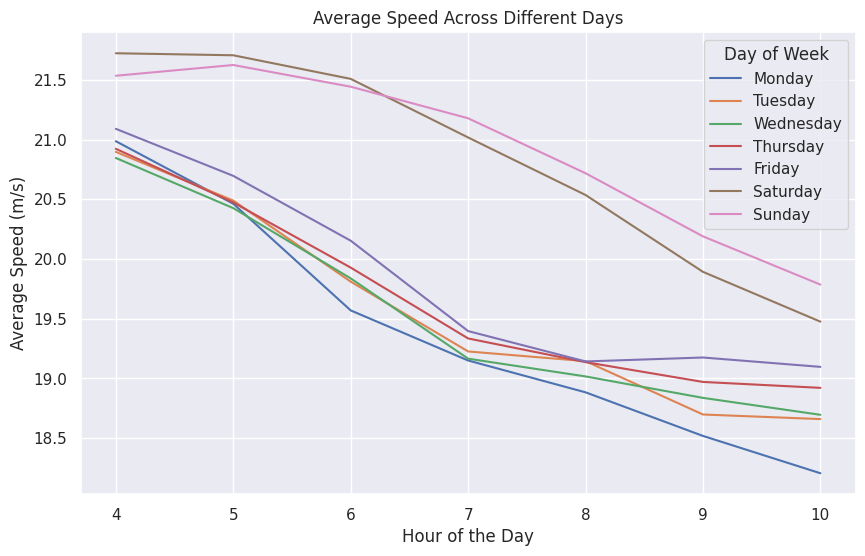

In [11]:
# average speed across the day for all months and days
plt.figure(figsize=(10, 6))

for month in unique_months:
    month_data = dataframe[dataframe['Month'] == month]
    hourly_avg_speed = month_data.groupby('Hour')['SPEED_MS_AVG'].mean()
    plt.plot(hourly_avg_speed.index, hourly_avg_speed.values, label=f'{month}')

plt.legend(title='Month')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Speed (m/s)')
plt.title('Average Speed Across Different Months')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))


for day in ordered_days:
    day_data = dataframe[dataframe['Day'] == day]
    hourly_avg_speed = day_data.groupby('Hour')['SPEED_MS_AVG'].mean()
    plt.plot(hourly_avg_speed.index, hourly_avg_speed.values, label=f'{day}')

plt.legend(title='Day of Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Speed (m/s)')
plt.title('Average Speed Across Different Days')
plt.grid(True)
plt.show()

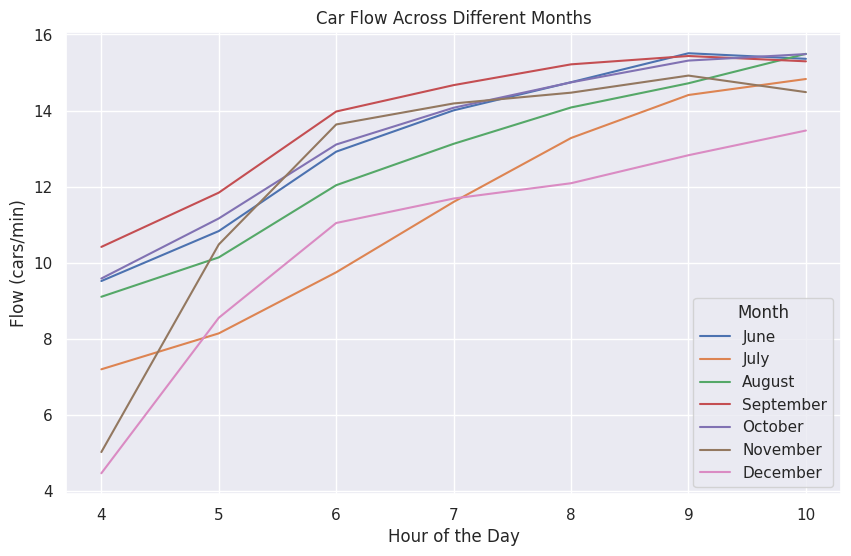

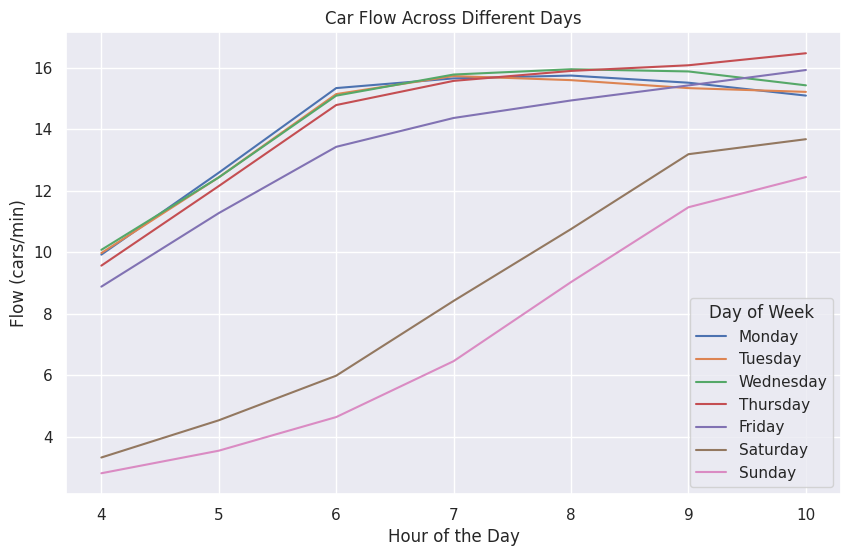

In [12]:
#average flow across the day for all months and days
plt.figure(figsize=(10, 6))

for month in unique_months:
    month_data = dataframe[dataframe['Month'] == month]
    hourly_avg_speed = month_data.groupby('Hour')['FLOW'].mean()
    plt.plot(hourly_avg_speed.index, hourly_avg_speed.values, label=f'{month}')

plt.legend(title='Month')
plt.xlabel('Hour of the Day')
plt.ylabel('Flow (cars/min)')
plt.title('Car Flow Across Different Months')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))

for day in ordered_days:
    day_data = dataframe[dataframe['Day'] == day]
    hourly_avg_speed = day_data.groupby('Hour')['FLOW'].mean()
    plt.plot(hourly_avg_speed.index, hourly_avg_speed.values, label=f'{day}')

plt.legend(title='Day of Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Flow (cars/min)')
plt.title('Car Flow Across Different Days')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


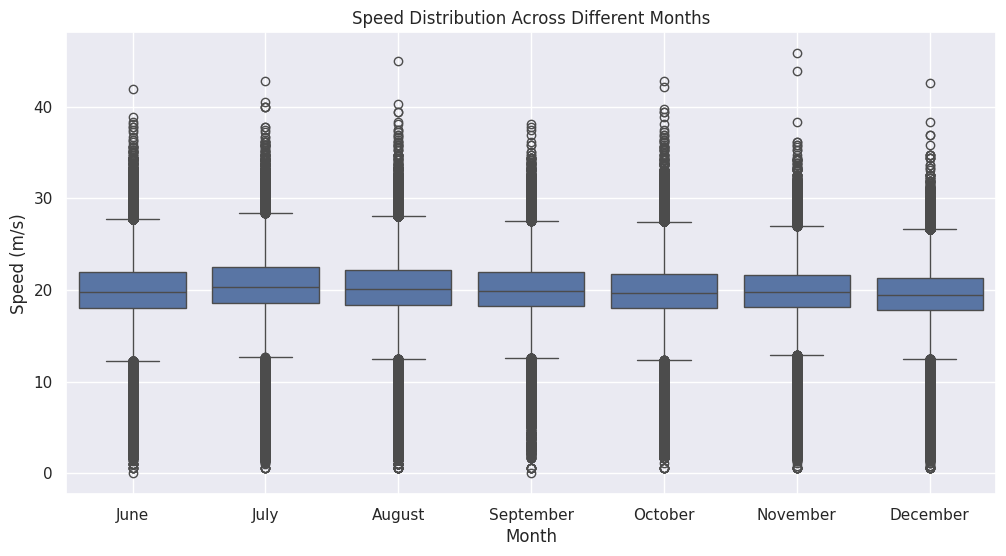

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


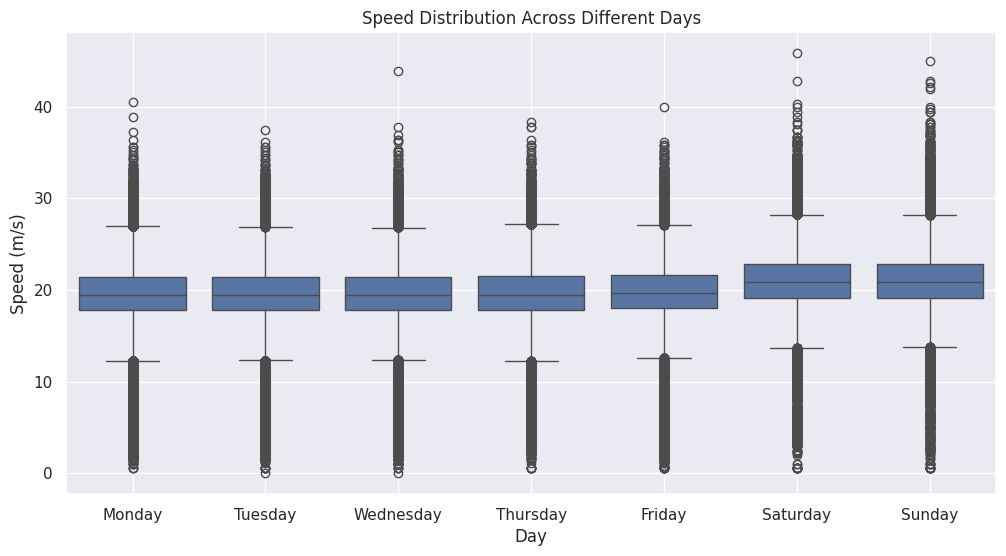

In [13]:
# Visualization: Speed patterns across different months
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='SPEED_MS_AVG', data=dataframe, order=['June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Speed Distribution Across Different Months')
plt.ylabel('Speed (m/s)')
plt.xlabel('Month')
plt.grid(True)
plt.show()

#Speed patterns across different weekdays
plt.figure(figsize=(12, 6))
sns.boxplot(x='Day', y='SPEED_MS_AVG', data=dataframe, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Speed Distribution Across Different Days')
plt.ylabel('Speed (m/s)')
plt.xlabel('Day')
plt.grid(True)
plt.show()

In [14]:
# drop unnecessary data
df = dataframe.drop(columns = ['Rain', 'AirTemp'])
df

,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Day,Month,Hour,Day_ID,Month_ID
0,543,"E4S 56,780",2021-06-01,04:00:00,240,48,16,8,4,19.34,10.0,Tuesday,June,4,2,6
1,539,"E4S 56,160",2021-06-01,04:00:00,240,48,16,8,4,19.64,9.0,Tuesday,June,4,2,6
2,534,"E4S 56,780",2021-06-01,04:00:00,240,48,16,8,4,23.36,5.0,Tuesday,June,4,2,6
3,351,"E4S 56,490",2021-06-01,04:00:00,240,48,16,8,4,20.14,7.0,Tuesday,June,4,2,6
4,353,"E4S 57,055",2021-06-01,04:00:00,240,48,16,8,4,17.70,7.0,Tuesday,June,4,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921962,353,"E4S 57,055",2021-12-31,10:00:00,600,120,40,20,10,17.45,11.0,Friday,December,10,5,12
1921963,543,"E4S 56,780",2021-12-31,10:00:00,600,120,40,20,10,18.09,11.0,Friday,December,10,5,12
1921964,153,"E4S 56,490",2021-12-31,10:00:00,600,120,40,20,10,23.53,7.0,Friday,December,10,5,12
1921965,351,"E4S 56,490",2021-12-31,10:00:00,600,120,40,20,10,18.49,9.0,Friday,December,10,5,12


#3. Prepare for Modeling
In this section, the dataset is prepared for modeling by dropping unnecessary data, normalizing variables, and aggregating into larger time intervals.

In [15]:
# drop unnecessary data
df = df.drop(columns = ['Month', 'Day', 'Hour'])
df

,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Day_ID,Month_ID
0,543,"E4S 56,780",2021-06-01,04:00:00,240,48,16,8,4,19.34,10.0,2,6
1,539,"E4S 56,160",2021-06-01,04:00:00,240,48,16,8,4,19.64,9.0,2,6
2,534,"E4S 56,780",2021-06-01,04:00:00,240,48,16,8,4,23.36,5.0,2,6
3,351,"E4S 56,490",2021-06-01,04:00:00,240,48,16,8,4,20.14,7.0,2,6
4,353,"E4S 57,055",2021-06-01,04:00:00,240,48,16,8,4,17.70,7.0,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921962,353,"E4S 57,055",2021-12-31,10:00:00,600,120,40,20,10,17.45,11.0,5,12
1921963,543,"E4S 56,780",2021-12-31,10:00:00,600,120,40,20,10,18.09,11.0,5,12
1921964,153,"E4S 56,490",2021-12-31,10:00:00,600,120,40,20,10,23.53,7.0,5,12
1921965,351,"E4S 56,490",2021-12-31,10:00:00,600,120,40,20,10,18.49,9.0,5,12


In [16]:
##### Normalize Time #####

# Convert the 'Time' column to string if it's not already
df['Time'] = df['Time'].astype(str)

# Create a function to safely convert hh:mm:ss to seconds
def time_to_seconds(time_str):
    try:
        # Split the string by colon
        parts = time_str.split(':')
        if len(parts) == 3:  # Ensure it's a valid hh:mm:ss format
            hours = int(parts[0])
            minutes = int(parts[1])
            seconds = int(parts[2])
            return hours * 3600 + minutes * 60 + seconds
        else:
            return np.nan  # Return NaN for invalid entries
    except ValueError:
        return np.nan  # Return NaN if there's an error in conversion

# Apply the function to convert the 'Time' column to seconds
df['time_in_seconds'] = df['Time'].apply(time_to_seconds)

# Drop rows with invalid/malformed time entries (optional)
df = df.dropna(subset=['time_in_seconds'])

# Get the min and max time in seconds
min_time = df['time_in_seconds'].min()
max_time = df['time_in_seconds'].max()

# Normalize the time using min-max normalization to the range [-1, 1]
df['normalized_time'] = 2 * ((df['time_in_seconds'] - min_time) / (max_time - min_time)) - 1

# Drop the intermediate 'time_in_seconds'
df = df.drop(columns=['time_in_seconds'])


In [17]:
##### Normalize Date #####

# Convert the 'Date' column to datetime format with error handling for invalid dates

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # 'coerce' turns invalid dates into NaT (Not a Time)

# Drop rows with invalid dates (NaT values) if needed
df = df.dropna(subset=['Date'])

# Convert dates to Unix timestamp (in seconds) using `.view('int64')`
df['date_ts'] = df['Date'].view(np.int64) // 10**9  # Convert nanoseconds to seconds

# Get the min and max timestamps
min_ts = df['date_ts'].min()
max_ts = df['date_ts'].max()

# Normalize the timestamps using NumPy for efficiency (range [-1, 1])
df['normalized_date'] = 2 * ((df['date_ts'] - min_ts) / (max_ts - min_ts)) - 1

# Drop the 'date_ts' column
df = df.drop(columns=['date_ts'])

df

<ipython-input-17-0fb26352bbff>:11: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['date_ts'] = df['Date'].view(np.int64) // 10**9  # Convert nanoseconds to seconds


,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Day_ID,Month_ID,normalized_time,normalized_date
0,543,"E4S 56,780",2021-06-01,04:00:00,240,48,16,8,4,19.34,10.0,2,6,-1.0,-1.0
1,539,"E4S 56,160",2021-06-01,04:00:00,240,48,16,8,4,19.64,9.0,2,6,-1.0,-1.0
2,534,"E4S 56,780",2021-06-01,04:00:00,240,48,16,8,4,23.36,5.0,2,6,-1.0,-1.0
3,351,"E4S 56,490",2021-06-01,04:00:00,240,48,16,8,4,20.14,7.0,2,6,-1.0,-1.0
4,353,"E4S 57,055",2021-06-01,04:00:00,240,48,16,8,4,17.70,7.0,2,6,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921962,353,"E4S 57,055",2021-12-31,10:00:00,600,120,40,20,10,17.45,11.0,5,12,1.0,1.0
1921963,543,"E4S 56,780",2021-12-31,10:00:00,600,120,40,20,10,18.09,11.0,5,12,1.0,1.0
1921964,153,"E4S 56,490",2021-12-31,10:00:00,600,120,40,20,10,23.53,7.0,5,12,1.0,1.0
1921965,351,"E4S 56,490",2021-12-31,10:00:00,600,120,40,20,10,18.49,9.0,5,12,1.0,1.0


The following code aggregates the data into 5-minute intervals to make the data points more representative. In this process, a few variables are naturally dropped.

In [18]:
# Group by 'normalized_date', 'Interval_5', 'Day_ID', and 'Month_ID'
aggregate_over_5_min = df.groupby(['normalized_date', 'Interval_5', 'Day_ID', 'Month_ID']).agg(
    FLOW=('FLOW', 'sum'),
    SPEED_MS_AVG=('SPEED_MS_AVG', 'mean')
).reset_index()

# Group by 'normalized_date' to apply shifts within each day
aggregate_over_5_min['previous_flow'] = aggregate_over_5_min.groupby('normalized_date')['FLOW'].shift(1)
aggregate_over_5_min['previous_speed'] = aggregate_over_5_min.groupby('normalized_date')['SPEED_MS_AVG'].shift(1)

# Drop any rows with NaN values (i.e., the first row for each date after the shift)
aggregate_over_5_min = aggregate_over_5_min.dropna()

# View the result
aggregate_over_5_min


,normalized_date,Interval_5,Day_ID,Month_ID,FLOW,SPEED_MS_AVG,previous_flow,previous_speed
1,-1.0,49,2,6,1003.0,21.703784,891.0,21.810536
2,-1.0,50,2,6,1079.0,21.895306,1003.0,21.703784
3,-1.0,51,2,6,1468.0,20.586422,1079.0,21.895306
4,-1.0,52,2,6,1570.0,20.775238,1468.0,20.586422
5,-1.0,53,2,6,1602.0,20.535345,1570.0,20.775238
...,...,...,...,...,...,...,...,...
15617,1.0,116,5,12,912.0,20.902132,898.0,21.243623
15618,1.0,117,5,12,1025.0,21.108298,912.0,20.902132
15619,1.0,118,5,12,962.0,21.065038,1025.0,21.108298
15620,1.0,119,5,12,966.0,20.557574,962.0,21.065038


In [19]:
corr_matrix = aggregate_over_5_min.corr()
corr_matrix['FLOW'].sort_values(ascending=False)


,FLOW
FLOW,1.000000
previous_flow,0.948233
Interval_5,0.491310
Month_ID,-0.066491
normalized_date,-0.068123
Day_ID,-0.478099
previous_speed,-0.644681
SPEED_MS_AVG,-0.649128


In [20]:
corr_matrix = aggregate_over_5_min.corr()
corr_matrix['SPEED_MS_AVG'].sort_values(ascending=False)

,SPEED_MS_AVG
SPEED_MS_AVG,1.000000
previous_speed,0.937093
Day_ID,0.403067
normalized_date,-0.155025
Month_ID,-0.155847
Interval_5,-0.543495
FLOW,-0.649128
previous_flow,-0.675454


In [21]:
filtered_data = aggregate_over_5_min[aggregate_over_5_min['Day_ID'].isin([1, 2, 3, 4, 5])]
# drop unnecessary columns
filtered_data = aggregate_over_5_min.drop(columns=['Month_ID'])
filtered_data

,normalized_date,Interval_5,Day_ID,FLOW,SPEED_MS_AVG,previous_flow,previous_speed
1,-1.0,49,2,1003.0,21.703784,891.0,21.810536
2,-1.0,50,2,1079.0,21.895306,1003.0,21.703784
3,-1.0,51,2,1468.0,20.586422,1079.0,21.895306
4,-1.0,52,2,1570.0,20.775238,1468.0,20.586422
5,-1.0,53,2,1602.0,20.535345,1570.0,20.775238
...,...,...,...,...,...,...,...
15617,1.0,116,5,912.0,20.902132,898.0,21.243623
15618,1.0,117,5,1025.0,21.108298,912.0,20.902132
15619,1.0,118,5,962.0,21.065038,1025.0,21.108298
15620,1.0,119,5,966.0,20.557574,962.0,21.065038


#4. Modeling
In this section, the data is predicted using XGBoost and linear regression

In [22]:
# split the data into a training and test set

x = filtered_data.drop(['FLOW'], axis=1)
y = filtered_data['FLOW']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

##4.1 XGBoost

In [23]:
# grid search - hyperparameter tuning

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1]
}

# Create the GridSearchCV object with XGBRegressor
grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3, verbose=2, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best Parameters:", best_params)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1}
Best Score: 0.980831502874634


In [24]:
# train an XGBoost model

# Use the best parameters to create the final XGBRegressor model
best_xgb = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample']
)

# Fit the final model to the training data
best_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [25]:
# make predictions using the trained model

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_XG = best_xgb.predict(X_test)

# validate the model

mae = mean_absolute_error(y_test, y_pred_XG)
mse = mean_squared_error(y_test, y_pred_XG)
r2 = r2_score(y_test, y_pred_XG)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 76.35654030242266
Mean Squared Error: 11072.523636587883
R-squared: 0.9801022365185142


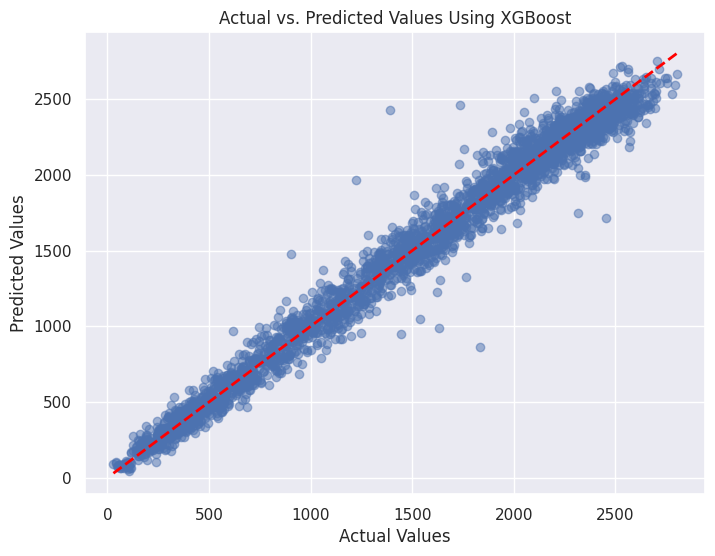

In [26]:
# visualize the predictions

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_XG, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values Using XGBoost")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

##4.2 Linear Regression

In [27]:
from sklearn.linear_model import LinearRegression

# Create a Linear Regression model
LRmodel = LinearRegression()

# Fit the model to the training data
LRmodel.fit(X_train, y_train)

# Predict the test data with the fitted model
y_pred = LRmodel.predict(X_test)

In [28]:
# evaluate model

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 122.79989130341873
Mean Squared Error: 54436.72561907919
R-squared: 0.9021750481980673


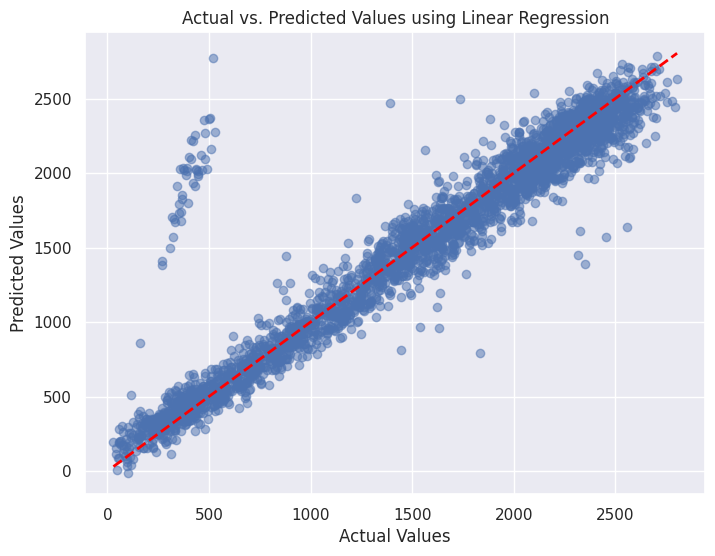

In [29]:
# visualize results

import matplotlib.pyplot as plt

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values using Linear Regression")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

#5. Evaluation Dataset

##5.1 Prepare the Data
Do the same type of preprocessing as for the training dataset, to achieve a dataset containing the same variables.

In [30]:
df_eval = pd.read_csv("final_evaluation_dataset.csv",sep=";")
df_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803501 entries, 0 to 803500
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   DP_ID         803501 non-null  int64  
 1   PORTAL        803501 non-null  object 
 2   Date          803501 non-null  int64  
 3   Time          803501 non-null  object 
 4   Interval_1    803501 non-null  int64  
 5   Interval_5    803501 non-null  int64  
 6   Interval_15   803501 non-null  int64  
 7   Interval_30   803501 non-null  int64  
 8   Interval_60   803501 non-null  int64  
 9   SPEED_MS_AVG  803501 non-null  float64
 10  FLOW          803497 non-null  float64
dtypes: float64(2), int64(7), object(2)
memory usage: 67.4+ MB


In [31]:
# check if date is in format yyyy-mm-dd
if not pd.api.types.is_datetime64_any_dtype(df_eval['Date']):
    # convert date to correct format if needed
    df_eval['Date'] = pd.to_datetime(df_eval['Date'].astype(str), format='%Y%m%d')

# create column for day of week, month, hour and minute
df_eval['Day'] = df_eval['Date'].dt.day_name()

# create ID corresponding to day of week and month to be able to remove all string variables
day_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
df_eval['Day_ID'] = df_eval['Day'].map(day_mapping)

##### Normalize Date #####
# Convert the 'Date' column to datetime format with error handling for invalid dates
df_eval['Date'] = pd.to_datetime(df_eval['Date'], errors='coerce')  # 'coerce' turns invalid dates into NaT (Not a Time)

# Drop rows with invalid dates (NaT values) if needed
df_eval = df_eval.dropna(subset=['Date'])

# Convert dates to Unix timestamp (in seconds) using `.view('int64')`
df_eval['date_ts'] = df_eval['Date'].view(np.int64) // 10**9  # Convert nanoseconds to seconds

# Get the min and max timestamps
min_ts = df_eval['date_ts'].min()
max_ts = df_eval['date_ts'].max()

# Normalize the timestamps using NumPy for efficiency (range [-1, 1])
df_eval['normalized_date'] = 2 * ((df_eval['date_ts'] - min_ts) / (max_ts - min_ts)) - 1

# Drop the 'date_ts' column
df_eval = df_eval.drop(columns=['date_ts'])

df_eval

<ipython-input-31-1e0f7793650e>:21: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df_eval['date_ts'] = df_eval['Date'].view(np.int64) // 10**9  # Convert nanoseconds to seconds


,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Day,Day_ID,normalized_date
0,4872,"E4S 56,780",2022-01-05,04:00:00,240,48,16,8,4,17.50,1.0,Wednesday,3,-1.0
1,4430,"E4S 57,435",2022-01-05,04:00:00,240,48,16,8,4,24.44,1.0,Wednesday,3,-1.0
2,4436,"E4S 57,820",2022-01-05,04:00:00,240,48,16,8,4,23.61,1.0,Wednesday,3,-1.0
3,1079,"E4S 56,780",2022-01-05,04:00:00,240,48,16,8,4,23.75,2.0,Wednesday,3,-1.0
4,1076,"E4S 55,620",2022-01-05,04:00:00,240,48,16,8,4,21.30,3.0,Wednesday,3,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803496,1079,"E4S 56,780",2022-06-30,10:00:00,600,120,40,20,10,16.77,20.0,Thursday,4,1.0
803497,1443,"E4S 57,055",2022-06-30,10:00:00,600,120,40,20,10,20.94,24.0,Thursday,4,1.0
803498,902,"E4S 56,490",2022-06-30,10:00:00,600,120,40,20,10,18.21,19.0,Thursday,4,1.0
803499,1076,"E4S 55,620",2022-06-30,10:00:00,600,120,40,20,10,17.53,22.0,Thursday,4,1.0


In [32]:
##### Aggregate Data #####
# Group by 'normalized_date', 'Interval_5', 'Day_ID', and 'Month_ID'
aggregate_over_5_min_eval = df_eval.groupby(['normalized_date', 'Interval_5', 'Day_ID']).agg(
    FLOW=('FLOW', 'sum'),
    SPEED_MS_AVG=('SPEED_MS_AVG', 'mean')
).reset_index()

# Group by 'normalized_date' to apply shifts within each day
aggregate_over_5_min_eval['previous_flow'] = aggregate_over_5_min_eval.groupby('normalized_date')['FLOW'].shift(1)
aggregate_over_5_min_eval['previous_speed'] = aggregate_over_5_min_eval.groupby('normalized_date')['SPEED_MS_AVG'].shift(1)

# Drop any rows with NaN values (i.e., the first row for each date after the shift)
aggregate_over_5_min_eval = aggregate_over_5_min_eval.dropna()

aggregate_over_5_min_eval

,normalized_date,Interval_5,Day_ID,FLOW,SPEED_MS_AVG,previous_flow,previous_speed
1,-1.0,49,3,274.0,20.511158,145.0,20.991370
2,-1.0,50,3,290.0,20.792941,274.0,20.511158
3,-1.0,51,3,256.0,20.561860,290.0,20.792941
4,-1.0,52,3,344.0,20.979223,256.0,20.561860
5,-1.0,53,3,384.0,20.734747,344.0,20.979223
...,...,...,...,...,...,...,...
6638,1.0,116,4,2299.0,18.997600,1994.0,19.773680
6639,1.0,117,4,2100.0,19.374597,2299.0,18.997600
6640,1.0,118,4,2111.0,18.889760,2100.0,19.374597
6641,1.0,119,4,2045.0,19.135120,2111.0,18.889760


In [33]:
filtered_data_eval = aggregate_over_5_min_eval[aggregate_over_5_min_eval['Day_ID'].isin([1, 2, 3, 4, 5])]

filtered_data_eval

,normalized_date,Interval_5,Day_ID,FLOW,SPEED_MS_AVG,previous_flow,previous_speed
1,-1.0,49,3,274.0,20.511158,145.0,20.991370
2,-1.0,50,3,290.0,20.792941,274.0,20.511158
3,-1.0,51,3,256.0,20.561860,290.0,20.792941
4,-1.0,52,3,344.0,20.979223,256.0,20.561860
5,-1.0,53,3,384.0,20.734747,344.0,20.979223
...,...,...,...,...,...,...,...
6638,1.0,116,4,2299.0,18.997600,1994.0,19.773680
6639,1.0,117,4,2100.0,19.374597,2299.0,18.997600
6640,1.0,118,4,2111.0,18.889760,2100.0,19.374597
6641,1.0,119,4,2045.0,19.135120,2111.0,18.889760


##5.2 XGBoost Model using Evaluation Dataset

In [34]:
# update the testing variables to instead contain the entire evaluation dataset
X_test_eval = filtered_data_eval.drop(['FLOW'], axis=1)
y_test_eval = filtered_data_eval['FLOW']

In [35]:
# make a prediction using the evaluation data and compute validation metrics
y_pred_XG = best_xgb.predict(X_test_eval)

# validate the model
mae = mean_absolute_error(y_test_eval, y_pred_XG)
mse = mean_squared_error(y_test_eval, y_pred_XG)
r2 = r2_score(y_test_eval, y_pred_XG)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 111.11451096326013
Mean Squared Error: 22187.738369269628
R-squared: 0.9412954038375354


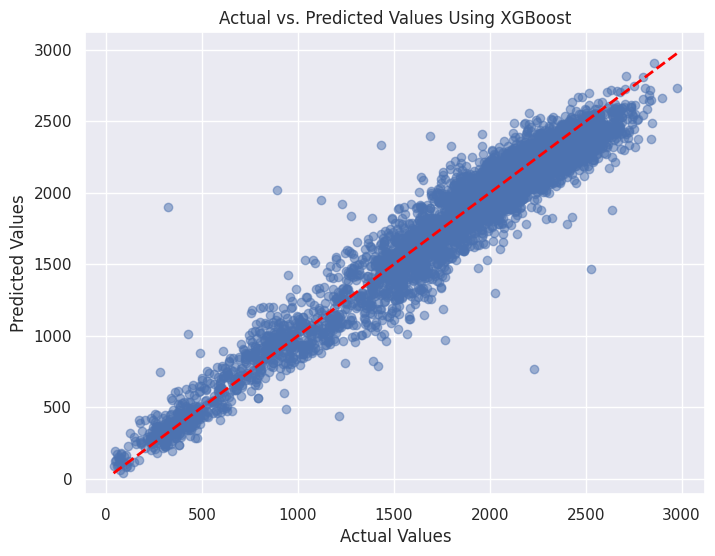

In [36]:
# visualize the predictions

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test_eval, y_pred_XG, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values Using XGBoost")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test_eval), max(y_test_eval)], [min(y_test_eval), max(y_test_eval)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

##5.3 Linear Regression using Evaluation Dataset

In [37]:
# Predict the test data with the fitted model
y_pred_LR = LRmodel.predict(X_test_eval)

In [38]:
# evaluate model

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_eval, y_pred_LR)
mse = mean_squared_error(y_test_eval, y_pred_LR)
r2 = r2_score(y_test_eval, y_pred_LR)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 131.7116356268067
Mean Squared Error: 57438.51672442428
R-squared: 0.8480284528166043


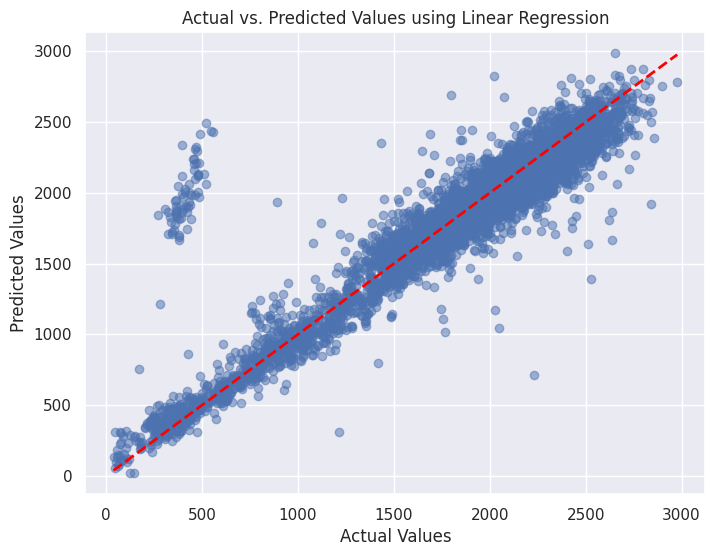

In [39]:
# visualize results

import matplotlib.pyplot as plt

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test_eval, y_pred_LR, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values using Linear Regression")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test_eval), max(y_test_eval)], [min(y_test_eval), max(y_test_eval)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()